In [18]:
from pandas import DataFrame, read_csv
import torch
import torch.nn as nn
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision.io import read_image
import os
import matplotlib.pyplot as plt
import zipfile

In [19]:
# unzip dataset
with zipfile.ZipFile("vehicle_classification.zip","r") as to_unzip:
    to_unzip.extractall()
print("Dataset Unzipped")

Dataset Unzipped


In [20]:
# create labels csv - convert string to int
types = os.listdir("vehicle_classification")
print(types)

conversion = {
    'Bicycle': 0,
    'Bus': 1,
    'Car': 2,
    'Motorcycle': 3,
    'NonVehicles': 4,
    'Taxi': 5,
    'Truck': 6,
    'Van': 7
}
labels = {}
for t in types:
    for img in os.listdir(f"vehicle_classification/{t}"):
        labels[f"{t}\\{img}"] = conversion[t]
df = DataFrame.from_dict(labels, orient='index', columns=["type"])

df.to_csv("labels.csv")

['Bicycle', 'Bus', 'Car', 'Motorcycle', 'NonVehicles', 'Taxi', 'Truck', 'Van']


In [21]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir):
        self.img_labels = read_csv(annotations_file)
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        
        label = self.img_labels.iloc[idx, 1]
        image = image.type_as(torch.FloatTensor())
        return image, label

In [22]:
data = CustomImageDataset(annotations_file="labels.csv", img_dir="vehicle_classification")
train_data, test_data = random_split(data, [0.8, 0.2])

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


feature_batch, label_batch = next(iter(train_dataloader))
print(f"Shape of features batch [N, C, H, W]: {feature_batch.shape}")
print(f"Length of label batch: {len(label_batch)}")
print(f"Type of X: {feature_batch.dtype}")
print(f"Type of y: {label_batch.dtype}")

Shape of features batch [N, C, H, W]: torch.Size([64, 3, 64, 64])
Length of label batch: 64
Type of X: torch.float32
Type of y: torch.int64


In [23]:
# use gpu/cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

def train(dataloader: DataLoader, model: nn.Module, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (feature, label) in enumerate(dataloader):
        feature, label = feature.to(device), label.to(device)
        pred = model(feature)
        loss = loss_fn(pred, label)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(feature)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (correct, test_loss)

def predict(data_loader, model, labels):
    correct, total = 0, 0
    model.eval()
    for x, y in data_loader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            pred = model(x)
            predicted, actual = labels[pred[0].argmax(0)], labels[y[0].item()]
            if predicted == actual:
                correct += 1
            total += 1
    return correct/total

Using cuda device


In [26]:
# Define model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()        
        self.network = nn.Sequential (
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Flatten(),
            
            nn.Linear(in_features=13*13*64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=len(conversion))
        )

    def forward(self, x):
        return self.network(x)     

model = CNN().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=10816, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=256, bias=True)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=8, bias=True)
  )
)


In [27]:
epochs = 100

accs = []
test_losses = []
loss_increased = 0
num_actual_epochs = 0

# train
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    acc, loss = test(test_dataloader, model, loss_fn)
    accs.append(acc)
    test_losses.append(loss)
    num_actual_epochs += 1
    # stop training early if beginning to overfit
    if t > 0:
        if test_losses[t] > test_losses[t-1]:
            loss_increased += 1
        else: 
            loss_increased = 0
        if loss_increased >= 4:
            break
print("Finished!")

Epoch 1
-------------------------------
loss: 3.465894  [   64/21103]
loss: 1.753271  [ 6464/21103]
loss: 1.538274  [12864/21103]
loss: 1.089601  [19264/21103]
Test Error: 
 Accuracy: 60.8%, Avg loss: 1.195825 

Epoch 2
-------------------------------
loss: 1.497610  [   64/21103]
loss: 1.461285  [ 6464/21103]
loss: 1.384571  [12864/21103]
loss: 0.954142  [19264/21103]
Test Error: 
 Accuracy: 64.0%, Avg loss: 1.090211 

Epoch 3
-------------------------------
loss: 1.434991  [   64/21103]
loss: 1.366702  [ 6464/21103]
loss: 1.298838  [12864/21103]
loss: 0.882529  [19264/21103]
Test Error: 
 Accuracy: 65.8%, Avg loss: 1.031874 

Epoch 4
-------------------------------
loss: 1.382631  [   64/21103]
loss: 1.301457  [ 6464/21103]
loss: 1.230424  [12864/21103]
loss: 0.818251  [19264/21103]
Test Error: 
 Accuracy: 67.2%, Avg loss: 0.990980 

Epoch 5
-------------------------------
loss: 1.343318  [   64/21103]
loss: 1.229971  [ 6464/21103]
loss: 1.176106  [12864/21103]
loss: 0.779835  [19264

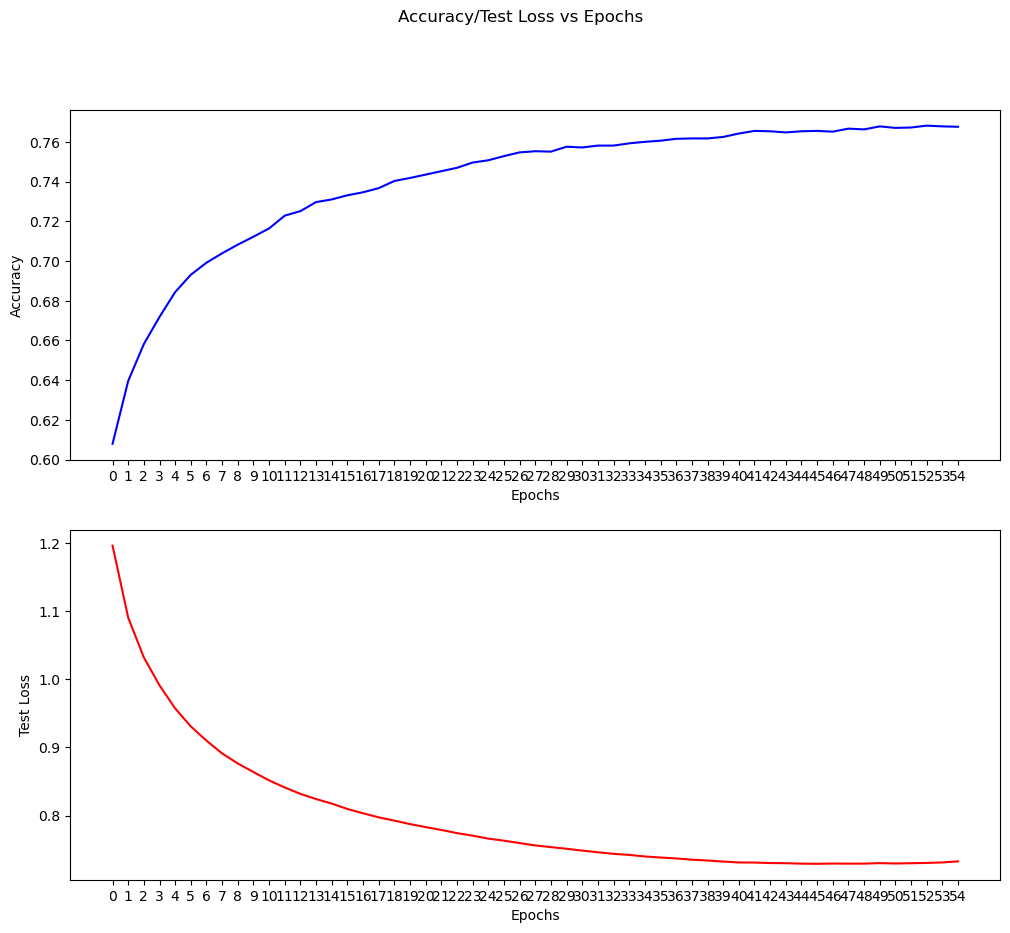

In [30]:
# plot
epoch_nums = range(num_actual_epochs)
top_plot, (accplt, lossplt) = plt.subplots(2, figsize=(12, 10))

top_plot.suptitle("Accuracy/Test Loss vs Epochs")
accplt.plot(epoch_nums, accs, c="blue")
accplt.set_xticks(epoch_nums)
accplt.set_ylabel("Accuracy")
accplt.set_xlabel("Epochs")


lossplt.plot(epoch_nums, test_losses, c="red")
lossplt.set_xticks(epoch_nums)
lossplt.set_ylabel("Test Loss")
lossplt.set_xlabel("Epochs")

plt.show()


In [31]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [32]:
classes = list(conversion.keys())

print(f"Train Set Accuracy: {predict(train_dataloader, model, classes)*100 :.2f}%")
print(f"Test Set Accuracy: {predict(test_dataloader, model, classes)*100 :.2f}%")

Train Set Accuracy: 86.36%
Test Set Accuracy: 74.70%
